# Exercise 1.1 - Simulate with fields

In [1]:
from pathlib import Path

import numpy as np
import numba
import scipy.interpolate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_

import soft_matter.sample
import soft_matter.energy
import soft_matter.dynamics

In [2]:
NUM_SEGMENTS = 16
A_SEGMENTS = 4

np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

### Show the fields in the micella

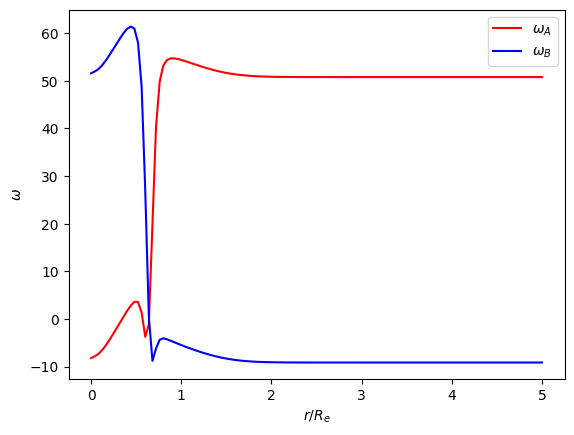

In [3]:
pos, phobic, philic = np.loadtxt(data_dir / "omega.dat", delimiter=" ", skiprows=1, dtype=np.float64).T
field_A = scipy.interpolate.interp1d(pos, phobic, fill_value=phobic[-1], bounds_error=False)
field_B = scipy.interpolate.interp1d(pos, philic, fill_value=philic[-1], bounds_error=False)

r = np.linspace(0, 5, num=1_000)
plt.plot(r, field_A(r), label="$\\omega_A$", color="r")
plt.plot(r, field_B(r), label="$\\omega_B$", color="b")
plt.ylabel("$\\omega$")
plt.xlabel("$r / R_e$")
plt.legend()
plt.savefig(figure_dir / "ex1_external_fields.pdf")

In [4]:
@numba.njit
def polymer_pos_to_rad(polymer):
    xs, ys, zs = polymer[..., 0], polymer[..., 1], polymer[..., 2]
    return np.sqrt(xs * xs + ys * ys + zs * zs)

def energy_with_external_fields(polymer):
    bond_energy = soft_matter.energy.total_bond_energy(polymer)
    xs, ys, zs = polymer.T
    polymer_rad = np.sqrt(xs * xs + ys * ys + zs * zs)
    aas, bbs = polymer_rad[:A_SEGMENTS], polymer_rad[A_SEGMENTS:]
    field_energy = np.sum(field_A(aas)) + np.sum(field_B(bbs))
    return bond_energy + field_energy / NUM_SEGMENTS

## Simulate with external fields

In [5]:
max_steps = 100_000
drop_start = 10_000
energy = energy_with_external_fields

old_polymer = soft_matter.sample.sample_initial(NUM_SEGMENTS)
ens = [old_polymer]
energy_old = energy(old_polymer)
for step in tqdm_(range(max_steps * NUM_SEGMENTS)):
    new_polymer = soft_matter.dynamics.polymer_step(old_polymer)
    energy_new = energy(new_polymer)

    acceptance_rate = np.exp(energy_old - energy_new)
    mc_number = np.random.rand()
    if mc_number < acceptance_rate:  # accepted
        ens.append(new_polymer)
        old_polymer = new_polymer
        energy_old = energy_new
    else:
        ens.append(old_polymer)  # rejected

ens = np.array(ens[drop_start * NUM_SEGMENTS:])

  0%|          | 0/1600000 [00:00<?, ?it/s]

## Analyze and validate the simulation

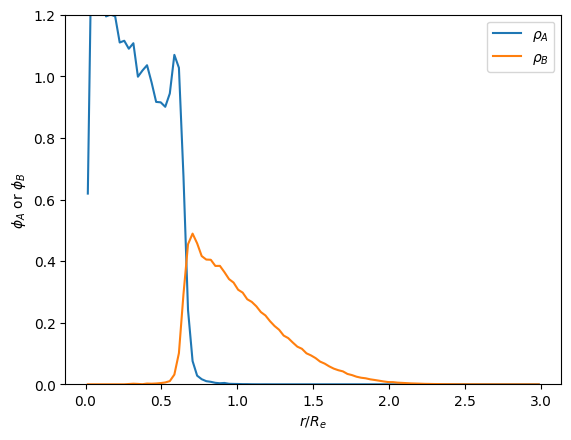

In [6]:
rad_ens = polymer_pos_to_rad(ens)
aa_rads, bb_rads = rad_ens[:, :A_SEGMENTS].flatten(), rad_ens[:, A_SEGMENTS:].flatten()

bins = np.linspace(0, 3, num=101)
bin_middles = (bins[1:] + bins[:-1]) / 2

aa_density, aa_edges = np.histogram(aa_rads, weights=aa_rads**-2, bins=bins)
bb_density, bb_edges = np.histogram(bb_rads, weights=bb_rads**-2, bins=bins)

norm = aa_density[11] + bb_density[11]  # used some number that fits well
plt.plot(bin_middles, aa_density / norm, label="$\\rho_A$")
plt.plot(bin_middles, bb_density / norm, label="$\\rho_B$")
plt.ylim(0, 1.2)
plt.ylabel("$\\phi_A$ or $\\phi_B$")
plt.xlabel("$r/R_e$")
plt.legend()

np.savetxt(data_dir / "ex1_partial_density_profile.dat", np.c_[bin_middles, aa_density / norm, bb_density / norm])
plt.savefig(figure_dir / "ex1_partial_density_profile.pdf")